In [11]:
import numpy as np
import pandas as pd
from environment.tetris import Tetris
from agents.DumbAgent import DumbAgent
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import matplotlib.pyplot as plt
from skopt import dummy_minimize,gp_minimize,forest_minimize
from skopt.space import Real
from skopt.utils import use_named_args
from skopt.plots import plot_convergence, plot_objective, plot_evaluations
import seaborn as sns
import os
from time import time
from functools import partial

sns.set_theme()
np.random.seed(42)
os.makedirs("results", exist_ok=True)

In [12]:
max_steps = 200
num_games = 2

In [19]:
def play_game(env, agent):
    env.reset()
    total_reward = 0
    for _ in range(max_steps):
        next_states = env.get_possible_states()
        best_action = agent.act(next_states)
        done, score, reward = env.step(*best_action)
        total_reward += reward

        if done:
            break

    return total_reward

env = Tetris(10, 20,use_level=False)

def play_single_game(weights):
    agent = DumbAgent(5, None, weights=weights)
    return play_game(env, agent)

In [24]:
space = [
    Real(-1, 1, name="cleared_lines"),
    Real(-1, 1, name="holes"),
    Real(-1, 1, name="bumpiness"),
    Real(-1, 1, name="max_height"),
    Real(-1, 1, name="check_pillar"),
]

@use_named_args(space)
def objective_function_named(**params):
    # Convert dictionary to list in the expected order
    weights = np.array([params[dim.name] for dim in space])

    if num_games == 1:
        return -play_single_game(weights)

    results = [play_single_game(weights) for _ in range(num_games)]

    mean_reward = np.mean(results)
    # print(f"Average reward: {mean_reward:.2f}")

    return -mean_reward

def run(minimizer, n_iter=4,**args):
    return [minimizer(objective_function_named, space, n_calls=150, random_state=n, **args)
            for n in tqdm(range(n_iter))]


# # Random search
# start = time()
# dummy_res = run(dummy_minimize)
# end = time()
# print(f"Dummy took: {(end-start):.2f}s, {((end-start)/60):.2f} min")

# # Gaussian processes
# start = time()
# gp_res = run(gp_minimize,acq_func = "EI",n_initial_points = 20)
# end = time()
# print(f"Gaussian took: {(end-start):.2f}s, {((end-start)/60):.2f} min")

# # Random forest
# start = time()
# rf_res = run(forest_minimize, base_estimator="RF",n_initial_points = 20)
# end = time()
# print(f"Random forest took: {(end-start):.2f}s, {((end-start)/60):.2f} min")

# Extra trees
start = time()
et_res = run(forest_minimize, base_estimator="ET",n_initial_points = 20)
end = time()
print(f"Extra trees took: {(end-start):.2f}s, {((end-start)/60):.2f} min")

# result = gp_minimize(
#         objective_function_named,
#         space,
#         n_calls=200,  # Total evaluations (includes n_initial_points)
#         n_initial_points=10,  # Initial random evaluations
#         acq_func="EI",  # Expected Improvement
#         n_jobs=-1,  # Use all available cores
#         verbose=False,
#     )



# optimal_weights = [gp_res.x[i] for i in range(len(space))]
# for name, value in zip([dim.name for dim in space], optimal_weights):
#     print(f"{name}: {value:.6f}")

  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 4/4 [28:09<00:00, 422.41s/it]

Extra trees took: 1689.63s, 28.16 min


In [ ]:
from skopt import dump,load
from copy import deepcopy
dummy_res1 = deepcopy(dummy_res)
dummy_res1.specs["args"]["func"] = None
dump(dummy_res1,"results/dummy_res.pkl")

# dump(gp_res,"results/gp_res.pkl")
# dump(rf_res,"results/rf_res.pkl")
# dump(et_res,"results/et_res.pkl")

PicklingError: Can't pickle <function objective_function_named at 0x000002B80C24EC00>: it's not the same object as __main__.objective_function_named

In [ ]:
# dummy_res_ = load("results/dummy_res.pkl")
# gp_res_ = load("results/gp_res.pkl")
# rf_res_ = load("results/rf_res.pkl")
# et_res_ = load("results/et_res.pkl")

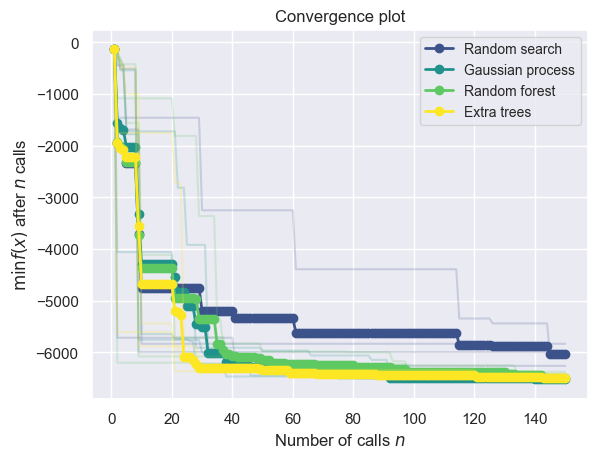

In [31]:
true_min = -(int(max_steps/10) * 1200) -20*max_steps

plot = plot_convergence(("Random search", dummy_res)
                        ,("Gaussian process", gp_res)
                        ,("Random forest", rf_res)
                        ,("Extra trees", et_res)
                        )#,true_minimum=true_min) #, yscale="log")

plot.legend(loc="best", prop={'size': 10}, numpoints=1)
plot.grid()
plt.savefig("results/convergence_comarison_between_models_no_min.png",dpi = 300,bbox_inches='tight')


In [ ]:
# np.save("gp_res/optimal_weights.npy", np.array(optimal_weights))

NameError: name 'optimal_weights' is not defined

cleared_lines: 1.000000
holes: -1.000000
bumpiness: -0.499642
max_height: -0.664018
check_pillar: -0.634201


<Figure size 1200x1000 with 0 Axes>

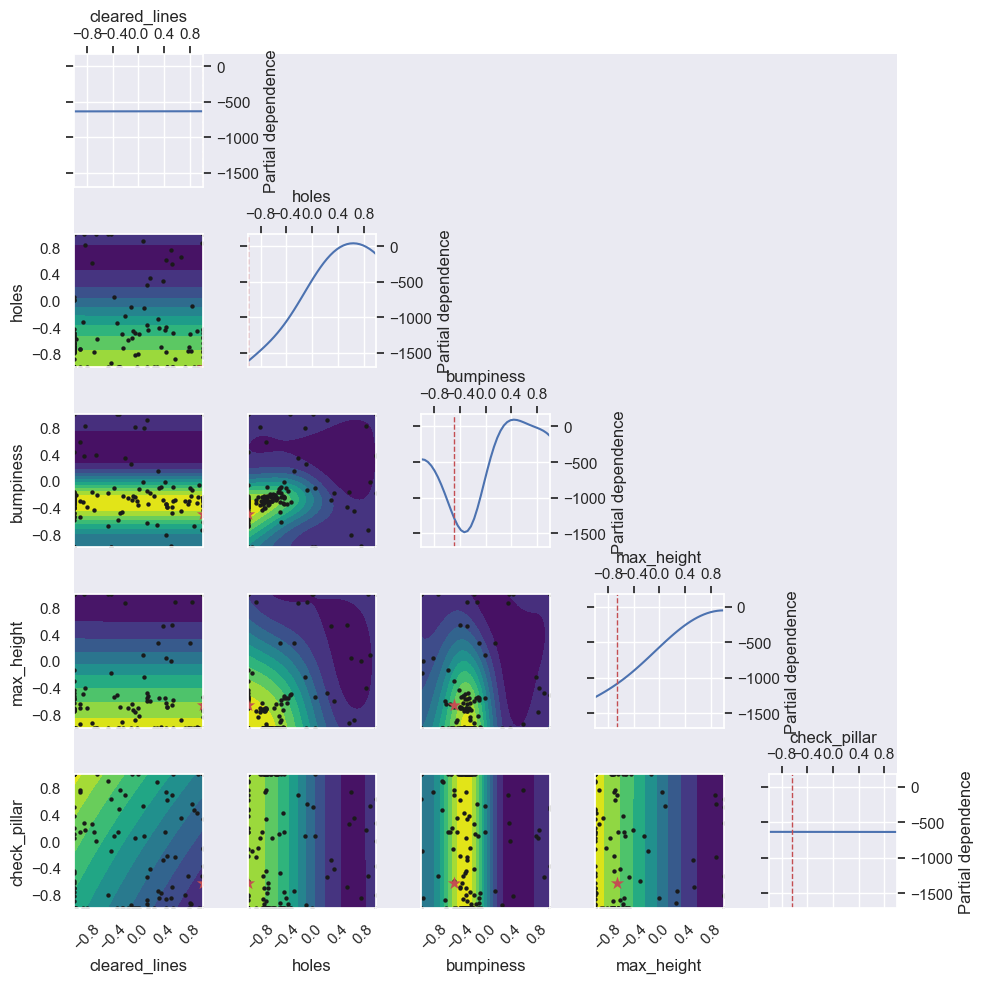

<Figure size 1200x1000 with 0 Axes>

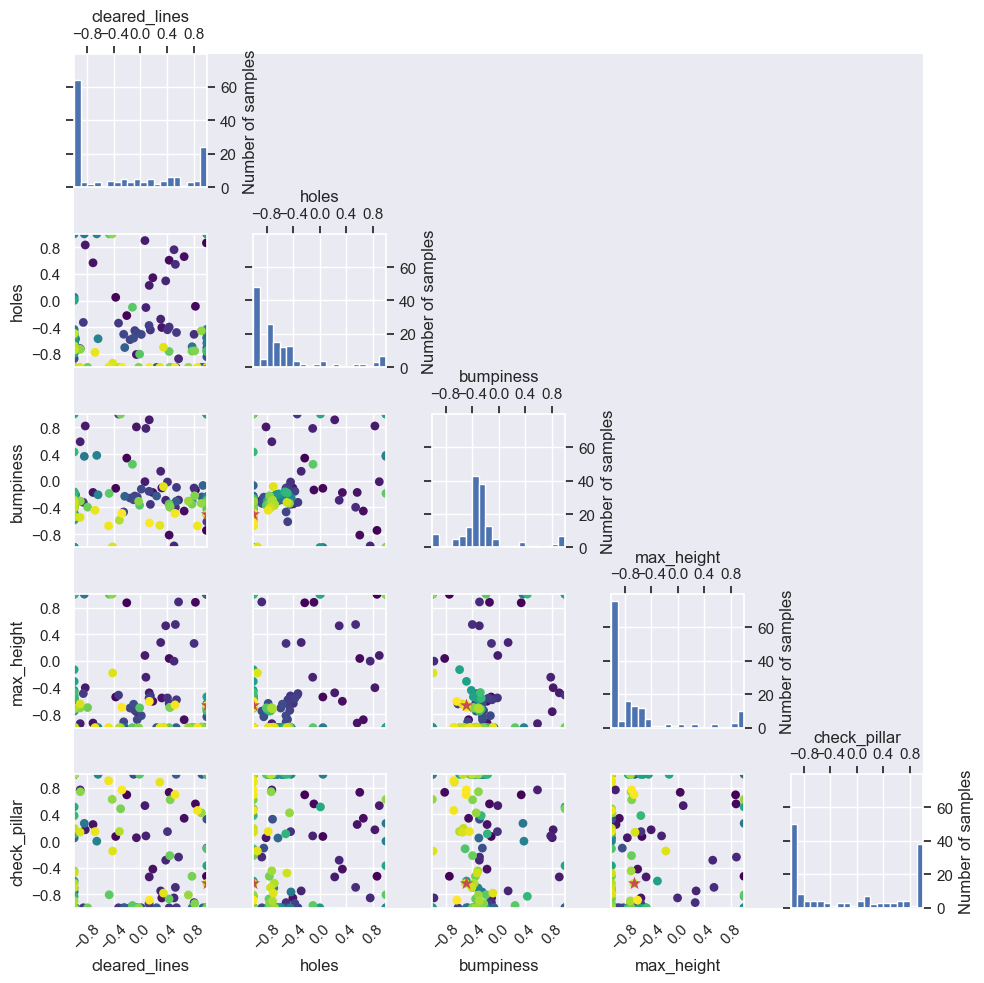

In [34]:
# plt.figure(figsize=(10, 6))
# plot_convergence(best_res)
# plt.tight_layout()
# plt.savefig("results/convergence.png")

best_res = min(gp_res,key=lambda r:r.fun)

# Plot and save objective function
plt.figure(figsize=(12, 10))
plot_objective(best_res)
plot.grid()
plt.tight_layout()
plt.savefig("results/objective.png")

# Plot and save evaluations
plt.figure(figsize=(12, 10))
plot_evaluations(best_res)
plot.grid()
plt.tight_layout()
plt.savefig("results/evaluations.png")

# Save detailed report
with open("results/report.txt", "w") as f:
    f.write(f"Number of evaluations: {len(best_res.x_iters)}\n")
    f.write(f"Best score: {-best_res.fun:.6f}\n")
    f.write("Optimal weights:\n")
    for name, value in zip([dim.name for dim in space], best_res.x):
        f.write(f"{name}: {value:.6f}\n")
    f.write("\nAll evaluations:\n")
    for i, (x, y) in enumerate(zip(best_res.x_iters, best_res.func_vals)):
        f.write(f"Iteration {i+1}: score={-y:.6f}, params={x}\n")

eval_df = pd.DataFrame(
    [list(x) + [-y] for x, y in zip(best_res.x_iters, best_res.func_vals)],
    columns=[dim.name for dim in space] + ["reward"],
)
eval_df.to_csv("results/evaluations.csv", index=False)

optimal_weights = [best_res.x[i] for i in range(len(space))]
for name, value in zip([dim.name for dim in space], optimal_weights):
    print(f"{name}: {value:.6f}")